# week9

## Image Compression

Every lossy compression system consists of three building blocks: one performing redundancy reduction, followed by one performing quantization, and finally one performing entropy encoding. What differentiates lossy and lossless compression is the middle block of quantization; the irreversible process of quantization is simply not utilized in lossless compression.

DPCM, fractal encoding, JPEG,... will be described.

Scalar and vector quantization are both lossy compressions. We will discuss several quantizers.

Lossy data compression consists in 
- Redundancy Removal (Predictor or Transform), 
- Entropy Reduction (Re-Quantization), 
- Lossless Coding (Huffman LZW Arithmetic).


### Scalar Quantization

The basic idea of Uniform Quantization is the following. We have to know the Decision Boundaries as well as the quantization level. In the following case, all we need to know is the step $\Delta$.


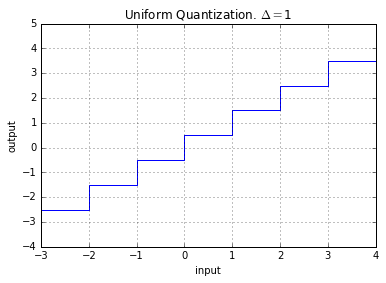

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Delta = 1 # 0.5

src = [-3,-3,-2,-2,-1,-1,0.,0.,1,1,2,2,3,3,4,4]
inp = np.array([k*Delta for k in src])
outs = [-3.5,-2.5,-2.5,-1.5,-1.5,-.5,-.5,.5,.5,1.5,1.5,2.5,2.5,3.5,3.5,4.5]
out = np.array([k*Delta for k in outs])

plt.plot(inp,out,'b-')
plt.xlabel('input')
plt.ylabel('output')
plt.title('Uniform Quantization. $\Delta=$'+str(Delta))
plt.grid('on')

Suppose we know the distribution of the pixels of an image. When we design the Quantizer, we want the error to be as small as possible, so... what quantizer to use? We would like to have a finer quantization in the middle of the bell shaped normal distribution, therefore smallest quantization error. In the extreme regions the quantization area will be bigger, and we will allow for a bigger quantization error.

$$
x \rightarrow Q(x) \rightarrow y_i \hspace{2cm} if \hspace{1cm} b_{i-1} < x < b_i
$$

with $b$ representing the bin. Let's look at the variance and the bit-rate $R$:

$$
\sigma^2_q = \sum_{i=1}^M \int \limits^{b_1}_{b_{i-1}} (x-y_i)^2 f_x(x)dx
$$

and

$$
R = \sum_{i=1}^M l_i \int \limits^{b_1}_{b_{i-1}} f_x(x)dx
$$

with $l_i$ being the codeword length. The optimal quantizer is obtained by minimizing the variance of quantization error. 

Let's study the unconstrained problem of quantization: Max-Lloyd Quantizer. With $p(f)$ the probability density function, and $r_i$ the reconstructed level:

$$
D=\sum^{L}_{i=1} \int \limits^{d_i}_{d_i-1} (r_i-f)^2 p(f) df
$$

Necessary conditions for minimum are:

$$
\frac{\partial D}{\partial r_k}=0, 1\leq k \leq L; \frac{\partial D}{\partial d_k}=0, 1 \leq k \leq L-1
$$

with:

$$
\frac{\partial D}{\partial r_k}=\int^{d_k}_{d_k-1} p(f)2(r_k-j) df=0 \hspace{2cm} r_k=\frac{\int^{d_k}_{d_k-1} f p(f) df}{\int^{d_k}_{d_k-1} p(f) df}
$$

i.e. the Centroid of probability mass in quantization interval.
We can use Leibnitz's formula to find the partial derivative.

$$
d_k=\frac{r_k + r_{k+1}}{2}
$$

If we use a uniform pdf $p(f)=c$, we obtain: $r_k=\frac{1}{2}(d_k+d_{k+1})$. 

If we use a non-uniform quantizer, we see that Gaussian and Laplacian distributions can be compared. 

The following example of Uniform Quantization can be done with VCdemo as well.

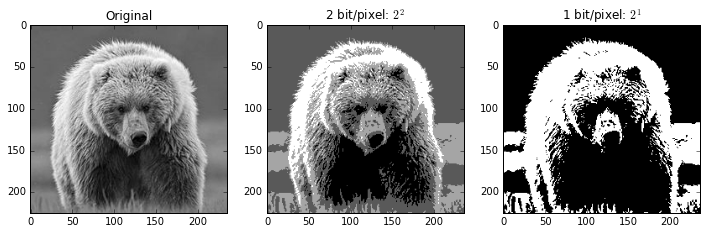

In [2]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal, misc, ndimage
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from skimage import exposure, img_as_float

I = misc.imread(os.path.join('media','bear.png') );
# read in the original, sharp and noise-free image
original = misc.imread(os.path.join('media','bear.png') , mode='L')/255.;
H = np.size(original,0)
W = np.size(original,1)
x = range(W)
y = range(H)
[X, Y] = np.meshgrid(x,y);

i_1bit = np.copy(original)
i_1bit[i_1bit>=1/2.]=np.mean(i_1bit[i_1bit>=1/2.])
i_1bit[i_1bit<1/2.]=np.mean(i_1bit[i_1bit<1/2.])
i_1bit255=np.floor(i_1bit*255.)

i_2bit = np.copy(original)
i_2bit[i_2bit>=3/4.]=np.mean(i_2bit[i_2bit>=3/4.])
i_2bit[i_2bit<1/4.]=np.mean(i_2bit[i_2bit<1/4.])
i_2bit[np.logical_and(i_2bit>=1/4.,i_2bit<1/2.)]=np.mean(i_2bit[np.logical_and(i_2bit>=1/4.,i_2bit<1/2.)])
i_2bit[np.logical_and(i_2bit>=1/2.,i_2bit<3/4.)]=np.mean(i_2bit[np.logical_and(i_2bit>=1/2.,i_2bit<3/4.)])
i_2bit255=np.floor(i_2bit*255.)

fig=plt.figure(figsize=(12, 8))
ax1=plt.subplot(1, 3, 1)
plt.imshow(original,cmap='gray')
plt.title('Original')

ax2 = fig.add_subplot(132)
plt.imshow(i_2bit,cmap='gray')
plt.title('2 bit/pixel: $2^2$')

ax1 = fig.add_subplot(133)
plt.imshow(i_1bit,cmap='gray')
plt.title('1 bit/pixel: $2^1$')


Companded quantization offers stretching of the image. Before the quantization we would apply a Compressor. After Compression we would apply an Expander. Compressor + Uniform Quantizer + Expander form a Non-Uniform Quantizer. Examples are mu-law or A-law.


### Vector Quantization

We can adapt the quantization to the distribution of the data. We do it similarly as with Max Lloyd procedure, refered to LGB. Given a signal, a number of pixels is considered as a block and grouped into vectors. The distance among code vectors is found and an index is formed, which will be passed to the decoder, that uses a lookup table to reconstruct the codebook. After that, we are ready to unblock.

So if we have $n$x$n$, then $L=2^l$ with $l$ number of bits and L the length of the block, and the efficiency or rate will be $\frac{nnb}{l}$. 

Say we have a $x$ quantizer and a $y$ quantizer. Certain combinations of $(x,y)$ are unprobable so there's no use for those particular blocks. We should use the correlated structure of the data.

Let's see an example.

In [3]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal, misc, ndimage
import numpy as np
import os
import matplotlib.pyplot as plt

# codebook y
i = [1,2,3,4]
y = [[0,0],[2,1],[1,3],[1,4]]

# signal
s = [0,1,2,3,2,0]

# 2dimensional:
group = 2

print 'codebook: ' + str(y) + ' , with index: ' + str(i)
print 'signal: ' + str(s)
print 'since the codebook is a 2d vector, we will group two samples together and find the distance:'

imin = list([])
# distance
for jj in range(len(s)/group):
    d2 = np.array([[np.power(y[0][0]-s[jj*group],2)+np.power(y[0][1]-s[jj*group+1],2)],
      [np.power(y[1][0]-s[jj*group],2)+np.power(y[1][1]-s[jj*group+1],2)],
      [np.power(y[2][0]-s[jj*group],2)+np.power(y[2][1]-s[jj*group+1],2)],
      [np.power(y[3][0]-s[jj*group],2)+np.power(y[3][1]-s[jj*group+1],2)]])
    imin.append(i[np.where(d2==min(d2))[0][0]])
      
print ''
print 'distance indexes -> Transmit to Decoder: ' + str(imin)
dum = imin[0]
imin_dec = imin
imin_dec.insert(0,[0][0])
imin_dec.insert(0,[0][0])
imin_dec.append(dum)
print 'Decoded signal: ' + str(imin_dec)
error = [kk-qq for kk,qq in zip(imin_dec,s)]
print 'Quantization error [difference]: ' + str(error)


codebook: [[0, 0], [2, 1], [1, 3], [1, 4]] , with index: [1, 2, 3, 4]
signal: [0, 1, 2, 3, 2, 0]
since the codebook is a 2d vector, we will group two samples together and find the distance:

distance indexes -> Transmit to Decoder: [1, 3, 2]
Decoded signal: [0, 0, 1, 3, 2, 1]
Quantization error [difference]: [0, -1, -1, 0, 0, 1]


VQ is very similar to Scalar Quantization. VQ [=designing codebook] can be a non-uniform quantizer? Data has underlying distribution usually and we want to tessellate non-uniformly, defining a vector centroid $y_1$ and an $x$ point. Based on the distance, I can perform the partition.

Let's see the Generalized Lloyd algorithm (LBG). 
- We begin with an initial Codebook $C_1$ of size $N$, with iteration counter $m=1$ and initial distortion $E_1=\infty$
- Using the codebook $C_m=\{y_i \}$, partition the training set into cluster sets $R_i$ using the Nearest Neighbor Condition.
- We find the centroid for these clusters.
- Calculate the average Energy (average distortion). If $E_m-E_{m+1}<T$.


### Differential Pulse-Code Modulation

Let's look at DPCM then, in which the error is quantized and then encoded.
We recall subsampling: we should low-pass filter it before doing that. PCM is using to requantize the intensity values of an image. We have an original image and we realize the 1bit image of it. At low rates, uniform noise rate is added (but it's known!) and then removed, which gives a multilevel image, similar to the starting one.

This is the DPCM:
- Most signals are predictable.
- This is possible because of autocorrelation.
- Anything that can be predicted from the signal's past can be reconstructed by the decoder, therefore only the unpreditable part (prediction error) needs to be encoded and sent to the decoder.
- Prediction coeffs $Ra=b;$ are $R$ autocorrelation values, $a$ predictions, $b$ autocorrelation values.

$x(n)$ has to be encoded. The difference betwwen Predicted signal $\hat{x}$ and signal $x$ gives the prediction error $\Delta x (n)$ which, in case of Lossy compression, is quantized qith a SQ or VQ, so that the Quantized prediction error $\Delta x' (n)$ is added to the Prediction and to the Reconstructed signal. It's kept in memory and the predictor is updated. Encoder and Decoder operate on the same data, which is the predicted signal $\hat{x}$. In DPCM, the Decoder is part of the Encoder. After the VLD, prediction+correction gives the reconstructed values of the signal. 

Prediction in DPCM is made of $x_i$ original signal. We want to predict $p_n=f(x_{n-1},x_{n-2},...,x_0)$ so that $\sigma^2_d=E[(x_n-p_n)^2]$ is minimum. Let's look at the linear predictor of order $n$. It will be $p_n=sum(a_i x_{n-i})$. The minimum is obtained as:

$$
\frac{\partial \sigma^2_d}{\partial a'_i}=0
$$

which gives the normal equation, with $R$ being the autocorrelation function:

$$
\sum^N_{i=1} a_i R_{xx}(i-i')=R_{xx}(i) \hspace{2cm} i=1,...,N
$$

with $R$ invertible. How do we find $R_{xx}$? We can use a model.

### Fractal Image Compression

It's another way to find self-similarity in the image through contractive operators. Decoder is a iterative algorithm. Image is encoded as a transformation. Also, a virtual code is used that does not have to be passed to the decoder, so it does not require transmission of a codebook. This is different from predictive encoding.

Fractal Coded Structure: In the Encoder we have a contractive operator $T$: $T(x)\approx x$. $T$ is passed, and sent to the decoder, that generates estimates iteratively where $x_0$ is arbitrary, $x_1=T(x_0)$, $x_2=T(x_1)=T^2(x_0)$ and so on...

$$
x=\lim_{k\rightarrow \infty} T^k (x_0)+e
$$

Given an image, we will look at all possible transformations that will make a block similar to another block, so that given a block $d_i$:

$$
r_i=P_i D_i I_i X_i d_i = T_i d_i
$$

where the objective is to get $r_i$. $X_i$ is a contractive operator. $I_i$ is isometry operator. $D_i$ is a decimator operator. $P_i$ is put operator. $T$ is a contractive operator if: 

$$
|T_{x_1}-T_{x_2}|\leq \alpha |x_1-x_2| \hspace{2cm} \alpha \leq 1
$$

As example, 
- Absorption at a certain gray level $x(i,j)=c$
- Luminance shift $x(i,j)-c$
- Contrast Scaling $c \cdot x(i,j)$
- Color reversal (such as Reverse of Intensity)

Not all transformations are applied to all blocks. Block types can be classified into:
- shade
- midrange
- edge

Let's look at Isometries now:

$$
|T_{x_1}-T_{x_2}|\leq |x_1-x_2|
$$

Examples are:
- Identity
- Vertical Reflection about mid-vertical (mid-orizontal, 1st diagonal, 2nd diagonal,...) axis
- Rotation around center of block through an angle [multiple of $\pi/2$].

VQ vs Fractal? VQ has a codebook. In Fractal it is virtual. In VQ we have to use a set of images. In Fractal it's just about that image. In Fractal encoding, the codebook transmission is not necessary. About Decoding, in VQ there's just a look-up table that is used.


### Transform Coding

We want to know how much the auto-correlation of an image is. That changes the compression. The composition of an image is given thanks to orthonormal decomposition. With uncorrelated images, we can use KL (Karhunen-Loeve) transformation, with basis as functions of the correlation of the image, i.e. it is unpractical. That's why trigonometric functions are used as DCT (Discrete Cosine Transform). What part to keep and what to discard?

With Transform coding we take the Transformation of the image block, and we take statistical independent coefficients. For coefficients that treat more, we use a fine (gentle) quantizer. With coefficients that contribute less, we use a coarse quantizer. Then, they are Entropy encoded, producing a Bitstream. In the decoder, there's an Inverse Quantization (Dequantization), after which the Inverse Transform is done.

Characteristics of Image Transforms:
- Image Decorrelation (Energy Compaction)
- Image Independent basis functions
- Fast Implementation

So: KLT results in statistical independent coefficients, but they are function of the encoded image. DCT is close to KLT for typical images, has efficient implementation, widely used in JPEG. Before going on let's define the inner product or dot (element-wise product) of blocks of an image. Given a set of $N$x$N$ orthonormal matrices $\left[ \phi^{(u,v)} \right]$, we can decompose it in terms of bases.

$$
\left[ f \right]=\sum_u \sum_v F(u,v) \left[ \phi^{(u,v)} \right]
$$

The image has to be projected in the orthonormal bases. In KLT also, we can find these matrices that result in orthonormal independent bases. In DCT, we should find $F(u,v)$, i.e. DCT coefficient.

After dividing the image, I could find the FFT and choose the best coefficients (by thresholding or by zonal approximaetion) for each block.

### JPEG

Consists of three basic blocks: Redundancy Reduction (DCT), Quantization (Uniform Quantizer based on the different location of the coefficients -> coarse quantizer for high frequencies), Entropy Encoding. In the last block, AC and DC are encoded differently. Differential Encoding is used fod DC. For AC, the block is first vecorized. 

Standard in 1991, formed in 1986, compression ration 10 to 50; 0.5 to 2bpp. 

The image is divided in 8x8 blocks, they are shifted ([-128,127]), DCT is taken for every block. After quantization, they are zig-zag scanned, to visit the DCT coefficients along a fixed path on the image. Afterwards, DC are encoded differentially from the DC coefficients of the neighboring block... the difference is going to be small for neighboring blocks. They are encoded by the Size codeword (T1) and Amplitude codeword (T2). With AC coefficients, they are first zigzag scanned, each non-zero coefficient is coded as runs followed by size (T3). Then the Amplitude is sent (T2).

Let's look at an example (highly adapted from here: http://bugra.github.io/work/notes/2014-07-12/discre-fourier-cosine-transform-dft-dct-image-compression/ ):

This is a typical jpeg quantizer:
[[   5.    6.    8.   16.   30.   50.   70.   74.]
 [  16.   17.   19.   27.   40.   60.   81.   85.]
 [  27.   27.   29.   36.   52.   72.   92.   94.]
 [  35.   36.   38.   49.   60.   81.  101.  107.]
 [  46.   48.   52.   59.   73.   94.  114.  114.]
 [  60.   60.   59.   67.   84.  103.  121.  127.]
 [  68.   71.   73.   77.   95.  111.  135.  139.]
 [  75.   78.   84.   88.  106.  120.  147.  146.]]


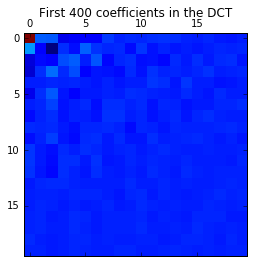

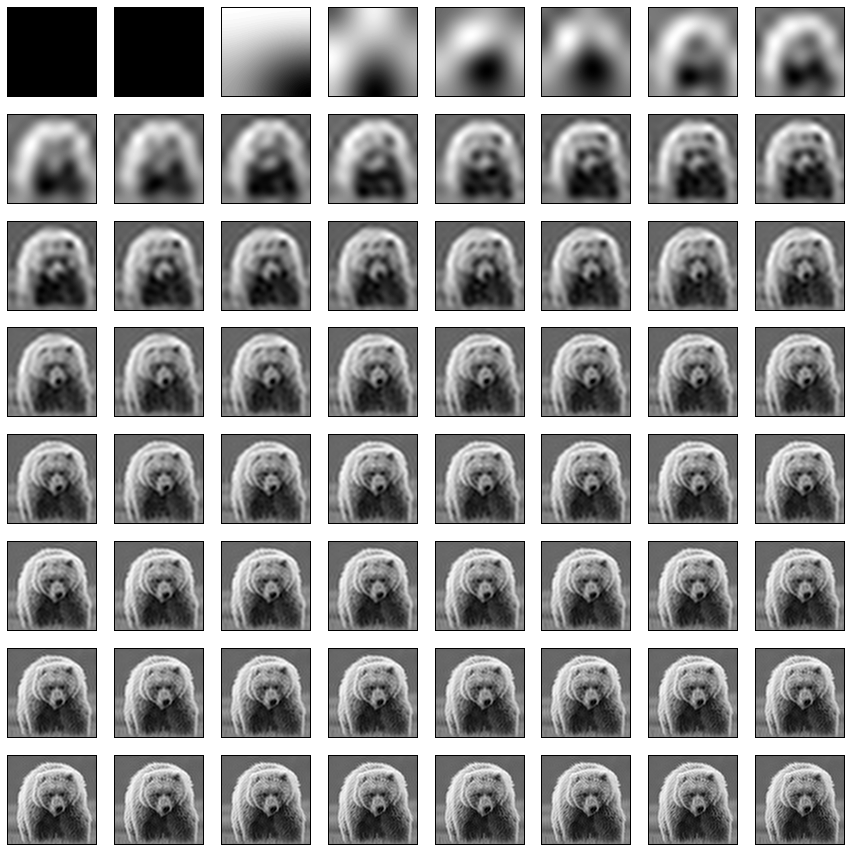

In [4]:
import io
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, ndimage

# take an image nxn
original = misc.imread(os.path.join('media','bear_nxn.png') , mode='L');
dct_size = original.shape[0]

# Get 2D Cosine Transform of Image
dct = fftpack.dct(fftpack.dct(original.T, norm='ortho').T, norm='ortho')
reconstructed_images = []

def get_reconstructed_image(raw):
    img = raw.clip(0, 255)
    img = img.astype('uint8')
    img = Image.fromarray(img)
    return img

for ii in range(dct_size):
    dct_copy = dct.copy()
    dct_copy[ii:,:] = 0
    dct_copy[:,ii:] = 0
    
    # Reconstructed image
    # Get 2D Inverse Cosine Transform of Image
    r_img = fftpack.idct(fftpack.idct(dct_copy.T, norm='ortho').T, norm='ortho');
    reconstructed_image = get_reconstructed_image(r_img);

    # Create a list of images
    reconstructed_images.append(reconstructed_image);
    
plt.matshow(dct[:20, :20]);
plt.title('First 400 coefficients in the DCT');

# quantize dct with a JPEG quantization table [random]:
qarr = np.array([5,  6,  8, 16, 30, 50, 70, 74])
qmat = np.empty((8,8))
for i in range(len(qarr)):
    qmat[i,:] = qarr+10.*i+np.floor(np.random.random(8)*(i+1))

print 'This is a typical jpeg quantizer:'
print qmat

# Upsample to the image size (224)
Q = ndimage.zoom(qmat, int(len(original)/len(qmat)), order=1)

# Quantize DCT coefficient with JPEG quantizer
coeff = np.floor(np.divide(dct,Q))

# Vectorize coeff
# Vcoeff = 

# After we work the coefficients as vector...
# Thern we reconstruct the signal with an inverse DCT

fig = plt.figure(figsize=(15, 15))
for ii in range(64):
    plt.subplot(8, 8, ii + 1)
    plt.imshow(reconstructed_images[ii], cmap=plt.cm.gray)
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);

### Subband Image Compression

We can consider subbands in the Frequency Domain. In Subband coding, we can adapt the compression scheme to the subband. We first use a filter to divide into subbands, each SB has reduced bandwidth. SBs have same or different bandwidths. Different rates or techniques can be used for any signal, for instance the Audio signals.

So how does it work? We have Analysis Filter and Sinthesis Sections. Band Pass Filters is first applied to each subband, we downsample and a number of encoders is implemented. After transmission, we have the Decoders for each subband, we upsample and we band pass filter. I could design a Sub-band Decomposition, by splitting in high and low frequencies, and creating many levels oh H and L. This is called quad-tree, which leads to a multi-rate subband decomposition, because bands have different size and rate.